In [7]:
import numpy as np
from qiskit import *

# 6. 펄스 스케줄 구성하기

#### 펄스 스케줄 - 펄스의 명령 시퀀스를 나타냄

In [1]:
from qiskit import pulse

with pulse.build(name='my_example') as my_program:
    # Add instructions here
    pass

my_program

# 명령어가 없는 빈 스케줄

ScheduleBlock(, name="my_example", transform=AlignLeft())

# 스케줄 명령어

* delay(duration, channel)

* play(pulse, channel)

* set_frequency(frequency, channel)

* shift_phase(phase, channel)

* acquire(duration, channel, mem_slot, reg_slot)

#### 명령어들 모두 channel을 피연산자로 가지고 있음

#### channel - 명령어가 어디에 적용될 것인지를 알려줌

* DriveChannel

* ControlChannel

* MeasureChannel

* AcquireChannel

In [2]:
from qiskit.pulse import DriveChannel

channel = DriveChannel(0)

#### 원래 channel은 backend와는 독립적이지만, backend를 인식하는 상황에서 구현할 수도 있고, 이게 나음

In [3]:
from qiskit.providers.fake_provider import FakeValencia

backend = FakeValencia()

with pulse.build(backend=backend, name='backend_aware') as backend_aware_program:
    channel = pulse.drive_channel(0)
    print(pulse.num_qubits())
    # Raises an error as backend only has 5 qubits
    #pulse.drive_channel(100)

5


# delay 명령어

#### 지정된 시간 간격동안 주어진 채널에 신호를 출력하지 않도록 차단 - 타이밍 조절에 유용

#### delay(duration, channel) 에서 channel에는 모든 채널 입력 가능, duration은 dt의 단위로 정수 값을 가짐

In [4]:
with pulse.build(backend) as delay_5dt:
    pulse.delay(5, channel)

#### 나중에 이 delay_5dt라는 스케줄에 추가된 구성은 5 timestep 뒤에 실행될 것임

# play 명령어

#### 펄스를 실행하는 명령어

In [6]:
with pulse.build() as sched:
    pulse.play(pulse, channel)

TypeError: object of type 'module' has no len()

#### pulse 변수 - 임의의 포락선 펄스

In [9]:
from qiskit.pulse import library

amp = 1
sigma = 10
num_samples = 128

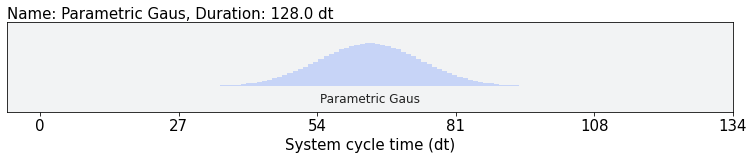

In [10]:
gaus = library.Gaussian(num_samples, amp, sigma,
                              name="Parametric Gaus")
gaus.draw()

In [11]:
#### Waveform을 통해서 

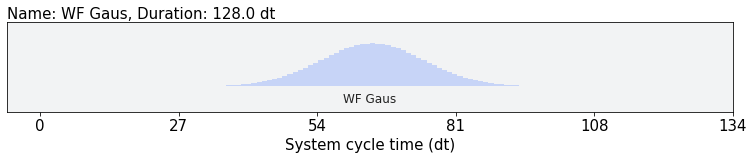

In [12]:
import numpy as np

times = np.arange(num_samples)
gaussian_samples = np.exp(-1/2 *((times - num_samples / 2) ** 2 / sigma**2))

gaus = library.Waveform(gaussian_samples, name="WF Gaus")
gaus.draw()

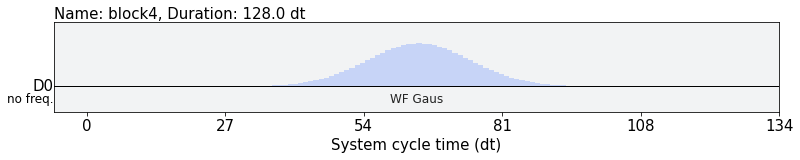

In [13]:
with pulse.build() as schedule:
    pulse.play(gaus, channel)
schedule.draw()

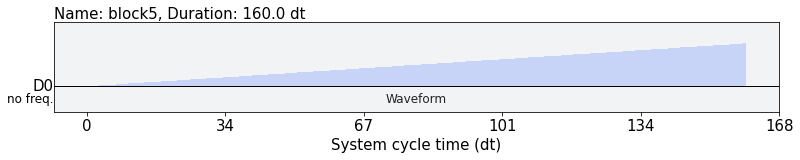

In [14]:
with pulse.build() as schedule:
    pulse.play([0.001*i for i in range(160)], channel)
schedule.draw()

# Set frequency 명령어

In [15]:
with pulse.build(backend) as schedule:
    pulse.set_frequency(4.5e9, channel)
    pulse.play([0.001*i for i in range(160)], channel)


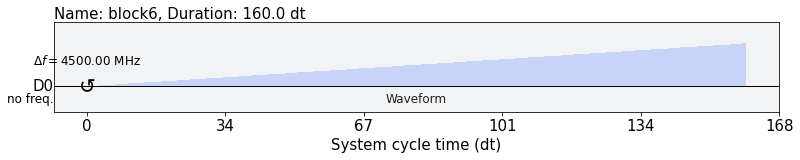

In [16]:
schedule.draw()

# Shift 명령어

In [17]:
with pulse.build(backend) as schedule:
    pulse.set_frequency(4.5e9, channel)
    pulse.play([0.001*i for i in range(160)], channel)
    pulse.shift_phase(np.pi, channel)

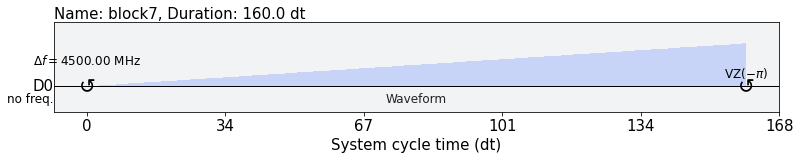

In [18]:
schedule.draw()

# acquire 명령어

In [19]:
from qiskit.pulse import Acquire, AcquireChannel, MemorySlot

with pulse.build(backend) as schedule:
    pulse.acquire(1200, pulse.acquire_channel(0), MemorySlot(0))

# 펄스 빌더

#### 스케줄을 작성하는 데에 있어서 편리한 기능 제공

## 정렬 컨텍스트(Align context)

# Align_left

#### 기본값으로 align_left 되어있응

#### 수행 시간이 다른 두 채널이 있을 때 왼쪽으로 정렬됨

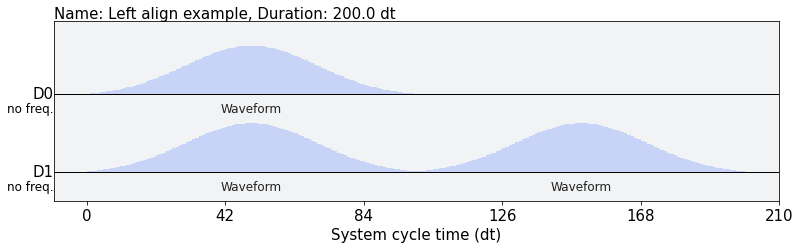

In [20]:
with pulse.build(backend, name='Left align example') as program:
    with pulse.align_left():
        gaussian_pulse = library.gaussian(100, 0.5, 20)
        pulse.play(gaussian_pulse, pulse.drive_channel(0))
        pulse.play(gaussian_pulse, pulse.drive_channel(1))
        pulse.play(gaussian_pulse, pulse.drive_channel(1))

program.draw()

# Align_right

#### align_left와 반대. 시간 자유도가 존재하는 스케줄을 최대한 오른쪽으로 붙여놓음

#### as soon as possible  vs  as late as possible

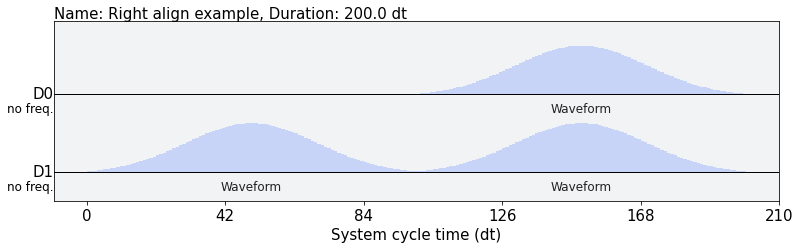

In [21]:
with pulse.build(backend, name='Right align example') as program:
    with pulse.align_right():
        gaussian_pulse = library.gaussian(100, 0.5, 20)
        pulse.play(gaussian_pulse, pulse.drive_channel(0))
        pulse.play(gaussian_pulse, pulse.drive_channel(1))
        pulse.play(gaussian_pulse, pulse.drive_channel(1))

program.draw()

# align_equispaced(duration)

# duration 시간 간격동안 실행시키는 것. 각 펄스를 대칭적으로 배치

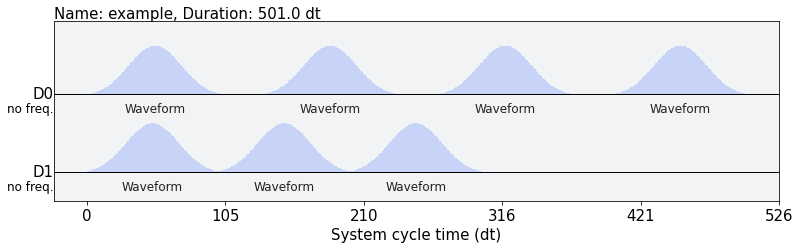

In [22]:
with pulse.build(backend, name='example') as program:
    gaussian_pulse = library.gaussian(100, 0.5, 20)
    with pulse.align_equispaced(500):
        pulse.play(gaussian_pulse, pulse.drive_channel(0))
        pulse.play(gaussian_pulse, pulse.drive_channel(0))
        pulse.play(gaussian_pulse, pulse.drive_channel(0))
        pulse.play(gaussian_pulse, pulse.drive_channel(0))

    pulse.play(gaussian_pulse, pulse.drive_channel(1))
    pulse.play(gaussian_pulse, pulse.drive_channel(1))
    pulse.play(gaussian_pulse, pulse.drive_channel(1))


program.draw()

# set_sequential 

#### 병렬적으로 배치하지 않고, 이전에 넣어준 지시사항이 끝나는 시간에 새로운 걸 넣어줌

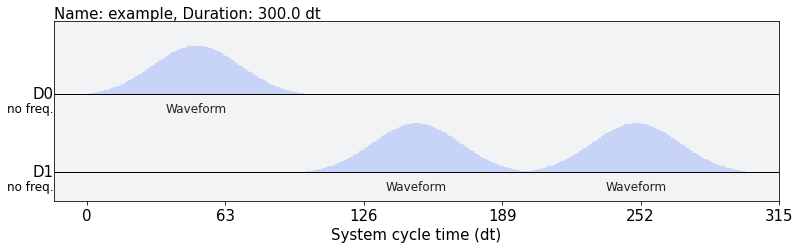

In [23]:
with pulse.build(backend, name='example') as program:
    with pulse.align_sequential():
        gaussian_pulse = library.gaussian(100, 0.5, 20)
        pulse.play(gaussian_pulse, pulse.drive_channel(0))
        pulse.play(gaussian_pulse, pulse.drive_channel(1))
        pulse.play(gaussian_pulse, pulse.drive_channel(1))

program.draw()

# offset

#### phase_offset 과 frequency_offset

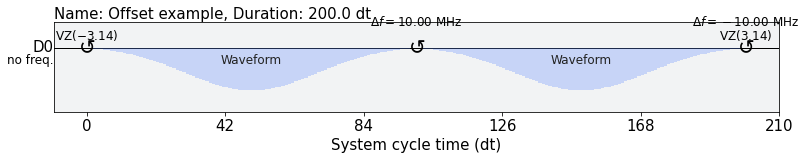

In [24]:
with pulse.build(backend, name='Offset example') as program:
    with pulse.phase_offset(3.14, pulse.drive_channel(0)):
        pulse.play(gaussian_pulse, pulse.drive_channel(0))
        with pulse.frequency_offset(10e6, pulse.drive_channel(0)):
            pulse.play(gaussian_pulse, pulse.drive_channel(0))

program.draw()